# Representation with a Feature Cross

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

# Load, scale, and shuffle

In [15]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

scale_factor = 1000.0
train_df["median_house_value"] /= scale_factor

test_df["median_house_value"] /= scale_factor

train_df = train_df.reindex(np.random.permutation(train_df.index))

# Keras Input tensors of float values

In [16]:
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude')
}

# Define functions to create and train a model, and a plotting functions

In [17]:
def create_model(my_inputs, my_outputs, my_learning_rate):

  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  epochs = history.epoch

  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse


def plot_the_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()

# Test 1

Epoch 1/30


c:\program files\python38\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 0s 1ms/step - loss: 20053.9102 - root_mean_squared_error: 141.6118
Epoch 2/30
170/170 [==============================] - 0s 1ms/step - loss: 13622.0088 - root_mean_squared_error: 116.7134
Epoch 3/30
170/170 [==============================] - 0s 1ms/step - loss: 13581.6445 - root_mean_squared_error: 116.5403
Epoch 4/30
170/170 [==============================] - 0s 1ms/step - loss: 13524.6436 - root_mean_squared_error: 116.2955
Epoch 5/30
170/170 [==============================] - 0s 1ms/step - loss: 13478.1689 - root_mean_squared_error: 116.0955
Epoch 6/30
170/170 [==============================] - 0s 1ms/step - loss: 13421.8701 - root_mean_squared_error: 115.8528
Epoch 7/30
170/170 [==============================] - 0s 1ms/step - loss: 13393.2773 - root_mean_squared_error: 115.7293
Epoch 8/30
170/170 [==============================] - 0s 1ms/step - loss: 13323.0488 - root_mean_squared_error: 115.4255
Epoch 9/30
170/170 [=======================

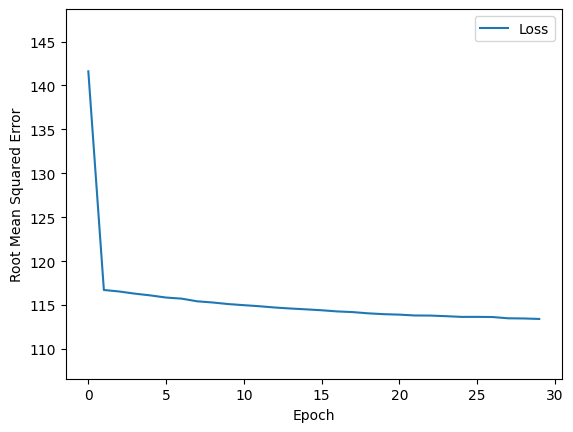


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 1ms/step - loss: 12192.6387 - root_mean_squared_error: 110.4203


[12192.638671875, 110.42028045654297]

In [18]:
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# The two Input layers are concatenated so they can be passed as a single
# tensor to a Dense layer.
preprocessing_layer = tf.keras.layers.Concatenate()(inputs.values())

dense_output = layers.Dense(units=1, name='dense_layer')(preprocessing_layer)

outputs = {
  'dense_output': dense_output
}

# Create and compile the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_model.png", show_shapes=True)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

# Represent features in buckets

In [19]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))
print("latitude boundaries: " + str(latitude_boundaries))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Number of categories is the length of latitude_boundaries plus one.
latitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(latitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Number of categories is the length of longitude_boundaries plus one.
longitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(longitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_longitude')(longitude)

# Concatenate latitude and longitude into a single tensor as input for the Dense layer.
concatenate_layer = tf.keras.layers.Concatenate()([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(concatenate_layer)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


# Test 2

Epoch 1/35
170/170 [==============================] - 1s 1ms/step - loss: 52091.9023 - root_mean_squared_error: 228.2365
Epoch 2/35
170/170 [==============================] - 0s 1ms/step - loss: 44684.7188 - root_mean_squared_error: 211.3876
Epoch 3/35
170/170 [==============================] - 0s 1ms/step - loss: 38107.1406 - root_mean_squared_error: 195.2105
Epoch 4/35
170/170 [==============================] - 0s 1ms/step - loss: 32296.6855 - root_mean_squared_error: 179.7128
Epoch 5/35
170/170 [==============================] - 0s 1ms/step - loss: 27280.6504 - root_mean_squared_error: 165.1685
Epoch 6/35
170/170 [==============================] - 0s 1ms/step - loss: 23022.9102 - root_mean_squared_error: 151.7330
Epoch 7/35
170/170 [==============================] - 0s 1ms/step - loss: 19518.5586 - root_mean_squared_error: 139.7088
Epoch 8/35
170/170 [==============================] - 0s 1ms/step - loss: 16714.0312 - root_mean_squared_error: 129.2828
Epoch 9/35
170/170 [============

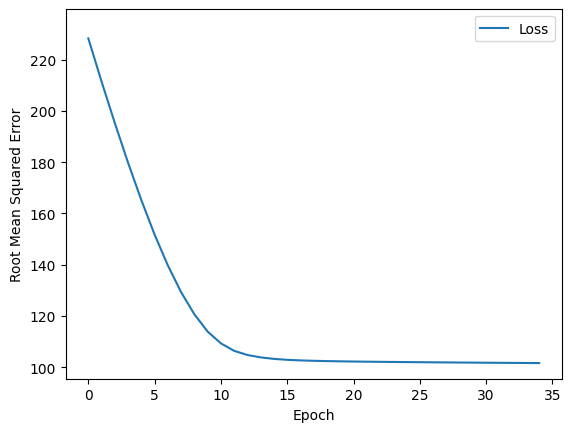


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 1ms/step - loss: 10197.2197 - root_mean_squared_error: 100.9813


[10197.2197265625, 100.98128509521484]

In [20]:
learning_rate = 0.04
epochs = 35

my_model = create_model(inputs, outputs, learning_rate)

epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

# Represent location as a feature cross

In [30]:
resolution_in_degrees = 0.4

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

# Test 3

Epoch 1/70
170/170 [==============================] - 0s 1ms/step - loss: 53042.2266 - root_mean_squared_error: 230.3090
Epoch 2/70
170/170 [==============================] - 0s 1ms/step - loss: 47217.3945 - root_mean_squared_error: 217.2956
Epoch 3/70
170/170 [==============================] - 0s 1ms/step - loss: 41828.6172 - root_mean_squared_error: 204.5205
Epoch 4/70
170/170 [==============================] - 0s 1ms/step - loss: 36940.7109 - root_mean_squared_error: 192.1997
Epoch 5/70
170/170 [==============================] - 0s 1ms/step - loss: 32482.0938 - root_mean_squared_error: 180.2279
Epoch 6/70
170/170 [==============================] - 0s 1ms/step - loss: 28484.7031 - root_mean_squared_error: 168.7741
Epoch 7/70
170/170 [==============================] - 0s 1ms/step - loss: 24924.3516 - root_mean_squared_error: 157.8745
Epoch 8/70
170/170 [==============================] - 0s 1ms/step - loss: 21800.1582 - root_mean_squared_error: 147.6488
Epoch 9/70
170/170 [============

170/170 [==============================] - 0s 1ms/step - loss: 7323.3096 - root_mean_squared_error: 85.5763
Epoch 70/70
170/170 [==============================] - 0s 1ms/step - loss: 7321.8960 - root_mean_squared_error: 85.5681
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 longitude (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 discretization_latitude (D  (None, 1)                    0         ['latitude[0][0]']            
 iscretization)                                              

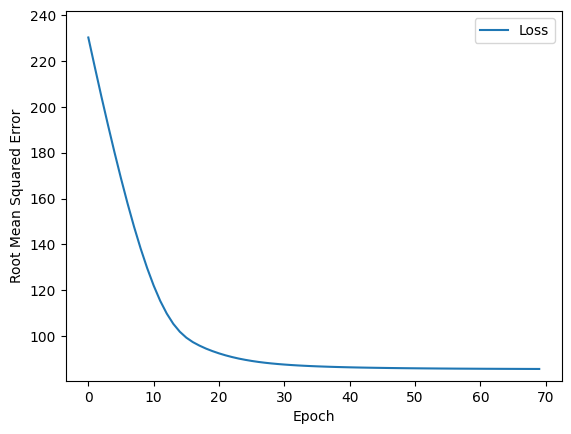


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 7614.2905 - root_mean_squared_error: 87.2599


[7614.29052734375, 87.25990295410156]

In [31]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 70

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)